In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import numpy as np

dec_data = np.loadtxt('/content/drive/MyDrive/Copy of Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_data.shape)
print(dec_train.shape)
print(dec_val.shape)
print(dec_test.shape)

(149, 254750)
(149, 203800)
(149, 50950)
(149, 159822)


In [ ]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU
# from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
# from keras.utils import np_utils

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = to_categorical(y, 3)
    return x, y

In [ ]:
k = 4 # which prediction horizon
T = 10 # the length of a single input i. e lookback_timestep THIS HYPERPARAMETER IS FINE TUNED FOR MODEL CONVERGENCE
n_hiddens = 64
checkpoint_filepath = '/content/drive/MyDrive/path_to_your_model_checkpoints/'
# checkpoint_filepath = './model_tensorflow2/weights'

In [ ]:
# Training Dataset Shrinking
# dec_train = dec_train[:,:50000]
print(dec_train.shape)
trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
print(trainX_CNN.shape, trainY_CNN.shape)

(149, 203800)
(203791, 10, 40, 1) (203791, 3)


In [ ]:
# Testing Dataset Shrinking
# dec_test = dec_test[:,:20000]
print(dec_test.shape)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)
print(testX_CNN.shape, testY_CNN.shape)

(149, 159822)
(159813, 10, 40, 1) (159813, 3)


In [ ]:

# Validation Dataset Shrinking
# dec_val = dec_val[:,:10000]
print(dec_val.shape)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
print(valX_CNN.shape, valY_CNN.shape)

(149, 50950)
(50941, 10, 40, 1) (50941, 3)


In [ ]:
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(203791, 10, 40, 1) (203791, 3)
(50941, 10, 40, 1) (50941, 3)
(159813, 10, 40, 1) (159813, 3)


In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))

    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)

    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)

    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
deeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 40, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 10, 20, 32)           96        ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 10, 20, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 10, 20, 32)           4128      ['leaky_re_lu[0][0]']         
                                                                                              

In [ ]:
%%time

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN),
            epochs=200, batch_size=128, verbose=2, callbacks=[model_checkpoint_callback])

Epoch 1/200
391/391 - 28s - loss: 0.9586 - accuracy: 0.4506 - val_loss: 1.1002 - val_accuracy: 0.4022 - 28s/epoch - 72ms/step
Epoch 2/200
391/391 - 6s - loss: 0.9228 - accuracy: 0.5164 - val_loss: 1.0844 - val_accuracy: 0.3994 - 6s/epoch - 15ms/step
Epoch 3/200
391/391 - 4s - loss: 0.8937 - accuracy: 0.5355 - val_loss: 1.0893 - val_accuracy: 0.4022 - 4s/epoch - 10ms/step
Epoch 4/200
391/391 - 4s - loss: 0.7751 - accuracy: 0.6185 - val_loss: 0.9868 - val_accuracy: 0.5033 - 4s/epoch - 11ms/step
Epoch 5/200
391/391 - 5s - loss: 0.6290 - accuracy: 0.7214 - val_loss: 0.8995 - val_accuracy: 0.5544 - 5s/epoch - 14ms/step
Epoch 6/200
391/391 - 4s - loss: 0.5597 - accuracy: 0.7588 - val_loss: 0.9990 - val_accuracy: 0.5138 - 4s/epoch - 10ms/step
Epoch 7/200
391/391 - 4s - loss: 0.5172 - accuracy: 0.7828 - val_loss: 0.9399 - val_accuracy: 0.5519 - 4s/epoch - 10ms/step
Epoch 8/200
391/391 - 5s - loss: 0.4818 - accuracy: 0.8014 - val_loss: 0.9787 - val_accuracy: 0.5526 - 5s/epoch - 13ms/step
Epoch 

KeyboardInterrupt: ignored

In [ ]:
deeplob.load_weights(checkpoint_filepath)
pred = deeplob.predict(testX_CNN)

625/625 [==============================] - 4s 5ms/step


In [ ]:
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.7796008203691661
              precision    recall  f1-score   support

           0     0.7919    0.7599    0.7755      7821
           1     0.7793    0.8911    0.8315      5457
           2     0.7651    0.7119    0.7376      6713

    accuracy                         0.7796     19991
   macro avg     0.7788    0.7876    0.7815     19991
weighted avg     0.7795    0.7796    0.7781     19991



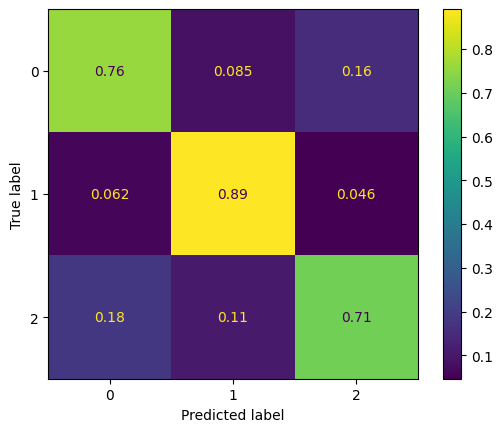

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
c = confusion_matrix(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()

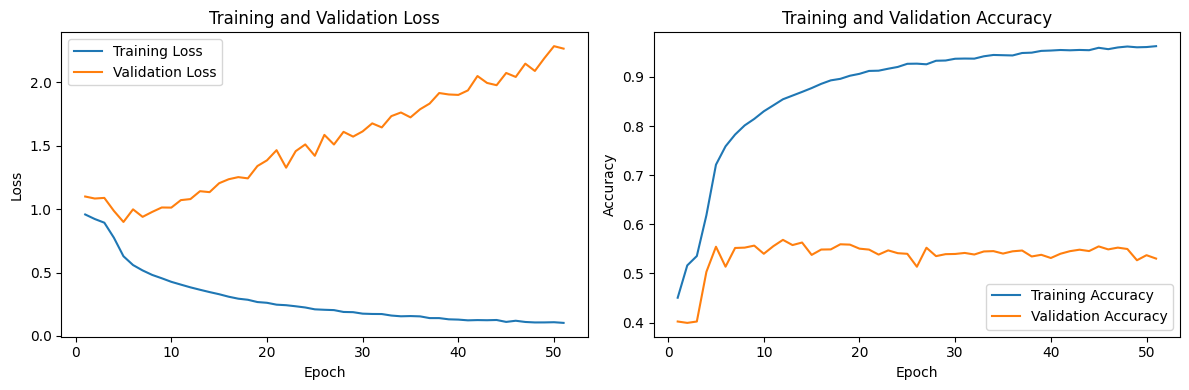

In [ ]:
import matplotlib.pyplot as plt

# Sample data from your training log
train_loss = [0.9586, 0.9228, 0.8937, 0.7751, 0.6290, 0.5597, 0.5172, 0.4818, 0.4554, 0.4273,
              0.4053, 0.3837, 0.3647, 0.3464, 0.3295, 0.3098, 0.2943, 0.2858, 0.2678, 0.2619,
              0.2471, 0.2429, 0.2344, 0.2249, 0.2103, 0.2068, 0.2042, 0.1896, 0.1880, 0.1762,
              0.1738, 0.1732, 0.1613, 0.1554, 0.1572, 0.1548, 0.1412, 0.1411, 0.1315, 0.1293,
              0.1235, 0.1255, 0.1244, 0.1262, 0.1111, 0.1203, 0.1106, 0.1069, 0.1071, 0.1086,
              0.1034]

val_loss = [1.1002, 1.0844, 1.0893, 0.9868, 0.8995, 0.9990, 0.9399, 0.9787, 1.0137, 1.0127,
            1.0718, 1.0800, 1.1422, 1.1347, 1.2052, 1.2366, 1.2532, 1.2434, 1.3407, 1.3857,
            1.4657, 1.3277, 1.4580, 1.5111, 1.4214, 1.5864, 1.5105, 1.6104, 1.5728, 1.6140,
            1.6773, 1.6453, 1.7344, 1.7631, 1.7246, 1.7884, 1.8334, 1.9165, 1.9052, 1.9018,
            1.9373, 2.0506, 1.9962, 1.9783, 2.0748, 2.0435, 2.1482, 2.0907, 2.1921, 2.2862,
            2.2668]

train_accuracy = [0.4506, 0.5164, 0.5355, 0.6185, 0.7214, 0.7588, 0.7828, 0.8014, 0.8146, 0.8301,
                  0.8423, 0.8546, 0.8621, 0.8696, 0.8774, 0.8860, 0.8931, 0.8962, 0.9025, 0.9064,
                  0.9123, 0.9128, 0.9168, 0.9204, 0.9268, 0.9271, 0.9258, 0.9330, 0.9335, 0.9371,
                  0.9375, 0.9373, 0.9421, 0.9448, 0.9443, 0.9438, 0.9488, 0.9495, 0.9531, 0.9538,
                  0.9549, 0.9543, 0.9550, 0.9545, 0.9594, 0.9566, 0.9601, 0.9620, 0.9604, 0.9609,
                  0.9627]

val_accuracy = [0.4022, 0.3994, 0.4022, 0.5033, 0.5544, 0.5138, 0.5519, 0.5526, 0.5567, 0.5401,
                0.5556, 0.5684, 0.5578, 0.5630, 0.5378, 0.5487, 0.5490, 0.5594, 0.5587, 0.5505,
                0.5486, 0.5384, 0.5470, 0.5413, 0.5400, 0.5137, 0.5524, 0.5353, 0.5393, 0.5397,
                0.5418, 0.5386, 0.5448, 0.5455, 0.5405, 0.5451, 0.5467, 0.5346, 0.5380, 0.5315,
                0.5401, 0.5454, 0.5484, 0.5456, 0.5551, 0.5490, 0.5526, 0.5498, 0.5269, 0.5372,
                0.5303]
epochs = list(range(1, 52))
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
